# Lip and Mouth extractors

***This notebook was executed in [Google colab](https://colab.research.google.com/), so for better experience we recomend executing it there.***


***Pay attention to the paths to files and folders and change them, so that they actually work in your case.***

*The main purpouse of this notebook was mouth and lips extraction from frames that were extracted from videos in order to use the frames to train models to perform Visual Speech Recognition.*


**Anyway, feel free to adjust this notebook for your specific needs.**

#### ***Results you may get using this notebook:***

<!-- Apologies for the photos that are not links to external images -->

***Lip extraction:***

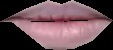




**Mouth extraction:**

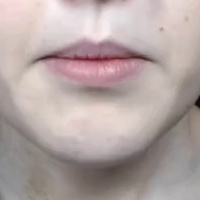



**Note:** Above images are for speaker number 15 from [Lombard Grid Corpus Dataset](https://spandh.dcs.shef.ac.uk//avlombard/)

## Setup

Import libraries

In [ ]:
import os
import cv2
import zipfile
import dlib
import numpy as np
import shutil

Conect to google colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Before we start extraction of lip or mouth frames we need to retrieve data from zip file that contains frames that we are going to parse.

In [ ]:
def extract_zip(zip_file_path, dest_folder_path):
    os.makedirs(dest_folder_path, exist_ok=True)
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(dest_folder_path)

Uncomment below if needed and specify your paths.

In [ ]:
# extract_zip("/content/drive/MyDrive/nn_course_work/video_frames.zip", "/content/drive/MyDrive/nn_course_work/video_frames")

## Atempt to write extraction script

Previous version of lip extraction:

In [ ]:
def init_vars():
  path_to_xml = 'haarcascade_mcs_mouth.xml'
  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  mouth_cascade = cv2.CascadeClassifier('path_to_xml')

  if mouth_cascade.empty():
    raise IOError('Unable to load the mouth cascade classifier xml file')

  return path_to_xml, face_cascade,  mouth_cascade 



def extract_lips(input_folder, output_folder, face_cascade, mouth_cascade):
    for root, dirs, files in os.walk(input_folder):
        for file in files:
            if file.endswith(".jpg") or file.endswith(".png"):
                img = cv2.imread(os.path.join(root, file))
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=3)
                for (x, y, w, h) in faces:
                    roi_gray = gray[y:y + h, x:x + w]
                    roi_color = img[y:y + h, x:x + w]
                    mouths = mouth_cascade.detectMultiScale(roi_gray, scaleFactor=1.3, minNeighbors=11)
                    for (ex, ey, ew, eh) in mouths:
                        roi_mouth = roi_color[ey:ey + eh, ex:ex + ew]
                        roi_mouth = cv2.resize(roi_mouth, (128, 64))
                        # Replace the input_folder path from root with the output_folder path
                        out_path = root.replace(input_folder, output_folder)
                        if not os.path.exists(out_path):
                            os.makedirs(out_path)
                        cv2.imwrite(os.path.join(out_path, file), roi_mouth)

***Above version was far from ideal and we did get wrong parts of the face.*** 

Here is what our results looked like:

<!-- Sorry for the format of the images -->

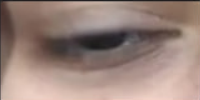


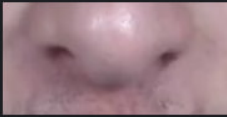

## Lip extraction

So we improved the exctraction script with the use of dlib library and pretrained models from there.

In [ ]:
# Load face detector and shape predictor from dlib
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("/content/drive/MyDrive/nn_course_work/shape_predictor_68_face_landmarks (2).dat")

# The indexes in the landmarks list of predictor output corresponding to the lips
OVERLIP_IDXS = list(range(48, 60))
UNDERLIP_IDXS = list(range(60, 68))

def extract_lip_images(speaker, subfolder, angle, src_folder="/content/drive/MyDrive/nn_course_work/video_frames", 
                       dst_folder="/content/drive/MyDrive/nn_course_work/video_frames_lips"):


    target_folder = os.path.join(src_folder, angle, speaker, subfolder, "/")
    for root, dirs, files in os.walk(target_folder):
        # Ensure we're in a directory for the current speaker
        if speaker not in root:
            continue  # Skip this directory if it's for a different speaker
        for file in files:
          
            if file.endswith(".jpg"):
                img_path = os.path.join(root, file)

                # Read the image
                img = cv2.imread(img_path)

                # Detect faces in the image
                faces = detector(img)

                # For now let's assume there's only one face in each image
                if len(faces) > 0:
                    face = faces[0]

                    # Get the landmarks/parts for the face.
                    shape = predictor(img, face)

                    # convert shape to numpy array
                    shape_np = np.array([(p.x, p.y) for p in shape.parts()])

                    # Identify the region around the lips
                    overlip = shape_np[OVERLIP_IDXS[0]:OVERLIP_IDXS[-1]]
                    underlip = shape_np[UNDERLIP_IDXS[0]:UNDERLIP_IDXS[-1]]

                    lip_points = np.concatenate((overlip, underlip))

                    # Create a mask for the lips
                    mask = np.zeros(img.shape[:2], dtype=np.uint8)
                    cv2.drawContours(mask, [lip_points], -1, (255), thickness=cv2.FILLED)

                    # Create a new image from the mask
                    lip_img = cv2.bitwise_and(img, img, mask=mask)

                    # Crop the lips region
                    (x, y, w, h) = cv2.boundingRect(np.array([lip_points]))
                    lip_img = lip_img[y:y + h, x:x + w]

                    # Write to the corresponding location in the destination folder
                    rel_dir = os.path.relpath(root, src_folder)
                    print("rel", rel_dir)
                    dst_dir = os.path.join(dst_folder, rel_dir)

                    # Create the directory if it doesn't exist
                    os.makedirs(dst_dir, exist_ok=True)

                    dst_path = os.path.join(dst_dir, file)
                    cv2.imwrite(dst_path, lip_img)

    print("Lip images extraction for speaker " + speaker + " and angle " + angle + " finished.")

*As you can see we use frontal face detector and face landmarks to find face at first and then landmarks from which we are able to extract lips only.* 

We extracted individual speakers one by one running code on 2-4 speakers, because it required a lot of time.

In [ ]:
for i in [18, 19, 20]:
  print(i)
  extract_lip_images(speaker=f"s{i}", subfolder="l", angle="front")

Writing for loop every time is not convinient, so we use method that we will use later on.

In [ ]:
def extract_lip_images_from_list(lst):
  for speaker_id, subfolder, angle in lst:
    print(f"Current speaker id {speaker_id}")
    extract_lip_images(speaker=f"s{speaker_id}", subfolder=f"{subfolder}", angle=f"{angle}")

Also creation of list with data for above method takes a lot of space(by this we mean a lot of code🤔) and we created below method that is just a wrapper which we may use for consecutive speakers.

In [ ]:
def extract_lip_images_wrapper(curr_lowwer, n, subfolder, angle):
  spk_ids = np.arange(curr_lowwer, curr_lowwer + n)
  subfolders = np.full(n, subfolder)
  angles = np.full(n, angle)
  lst = zip(spk_ids,  subfolders, angles)
  extract_lip_images_from_list(lst)

Let's extract 3 speakers: s15, s16, s17, s18.

In [ ]:
extract_lip_images_wrapper(15, 3, "l", "front")

Google drive space is not unbounded, so we need to clear up things from time to time and that is why we create method for this.

In [ ]:
def remove_folder(folder_path):
    shutil.rmtree(folder_path)

You may uncomment below code and use it for your paths. 

In [ ]:
# remove_folder("/content/drive/MyDrive/nn_course_work/video_frames_lips/video_frames/front/s17/")

Or you may use the wrapper method and modify it for your needs(if necessity arises).

In [ ]:
def remove_folder_wrapper(mode = 'test', type_mode='lips'):
  if mode == 'test':
    remove_folder(f"/content/drive/MyDrive/nn_course_work/video_frames_{type_mode}_test")
  elif mode == 'actual':
    remove_folder(f"/content/drive/MyDrive/nn_course_work/video_frames_{type_mode}")
  else:
    print(f"Mode variable should be assigned to value of 'actual' or 'test' and not {mode}")

Uncomment below call and modify it per your needs to delete directory.

In [ ]:
# remove_folder_wrapper('actual')

At first we used below code, because we did not know in [Google Drive](https://www.google.com/drive/) we can create zip folders and it works better than our script, so we wrote below method, but we leave it here in case you need it.

In [ ]:
def create_zip_from_folder(folder_path, zip_filename):
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, folder_path))

This is how you can use above method to create zip from folder(uncomment below code and adjust it in case you want to call the method).

In [ ]:
# create_zip_from_folder("/content/drive/MyDrive/nn_course_work/video_frames_lips/video_frames/front", "/content/lips_15_17.zip")

## Mouth extraction

Lips extraction is important for us, but lips may not provide us with the enough information for our models, so we need to create mouth extraction script which you may update and use for other parts of the face.


Here is the face landmarks, so that you will not need to find them by yourself.

<!-- Again sorry that it is not a link to an image =( -->

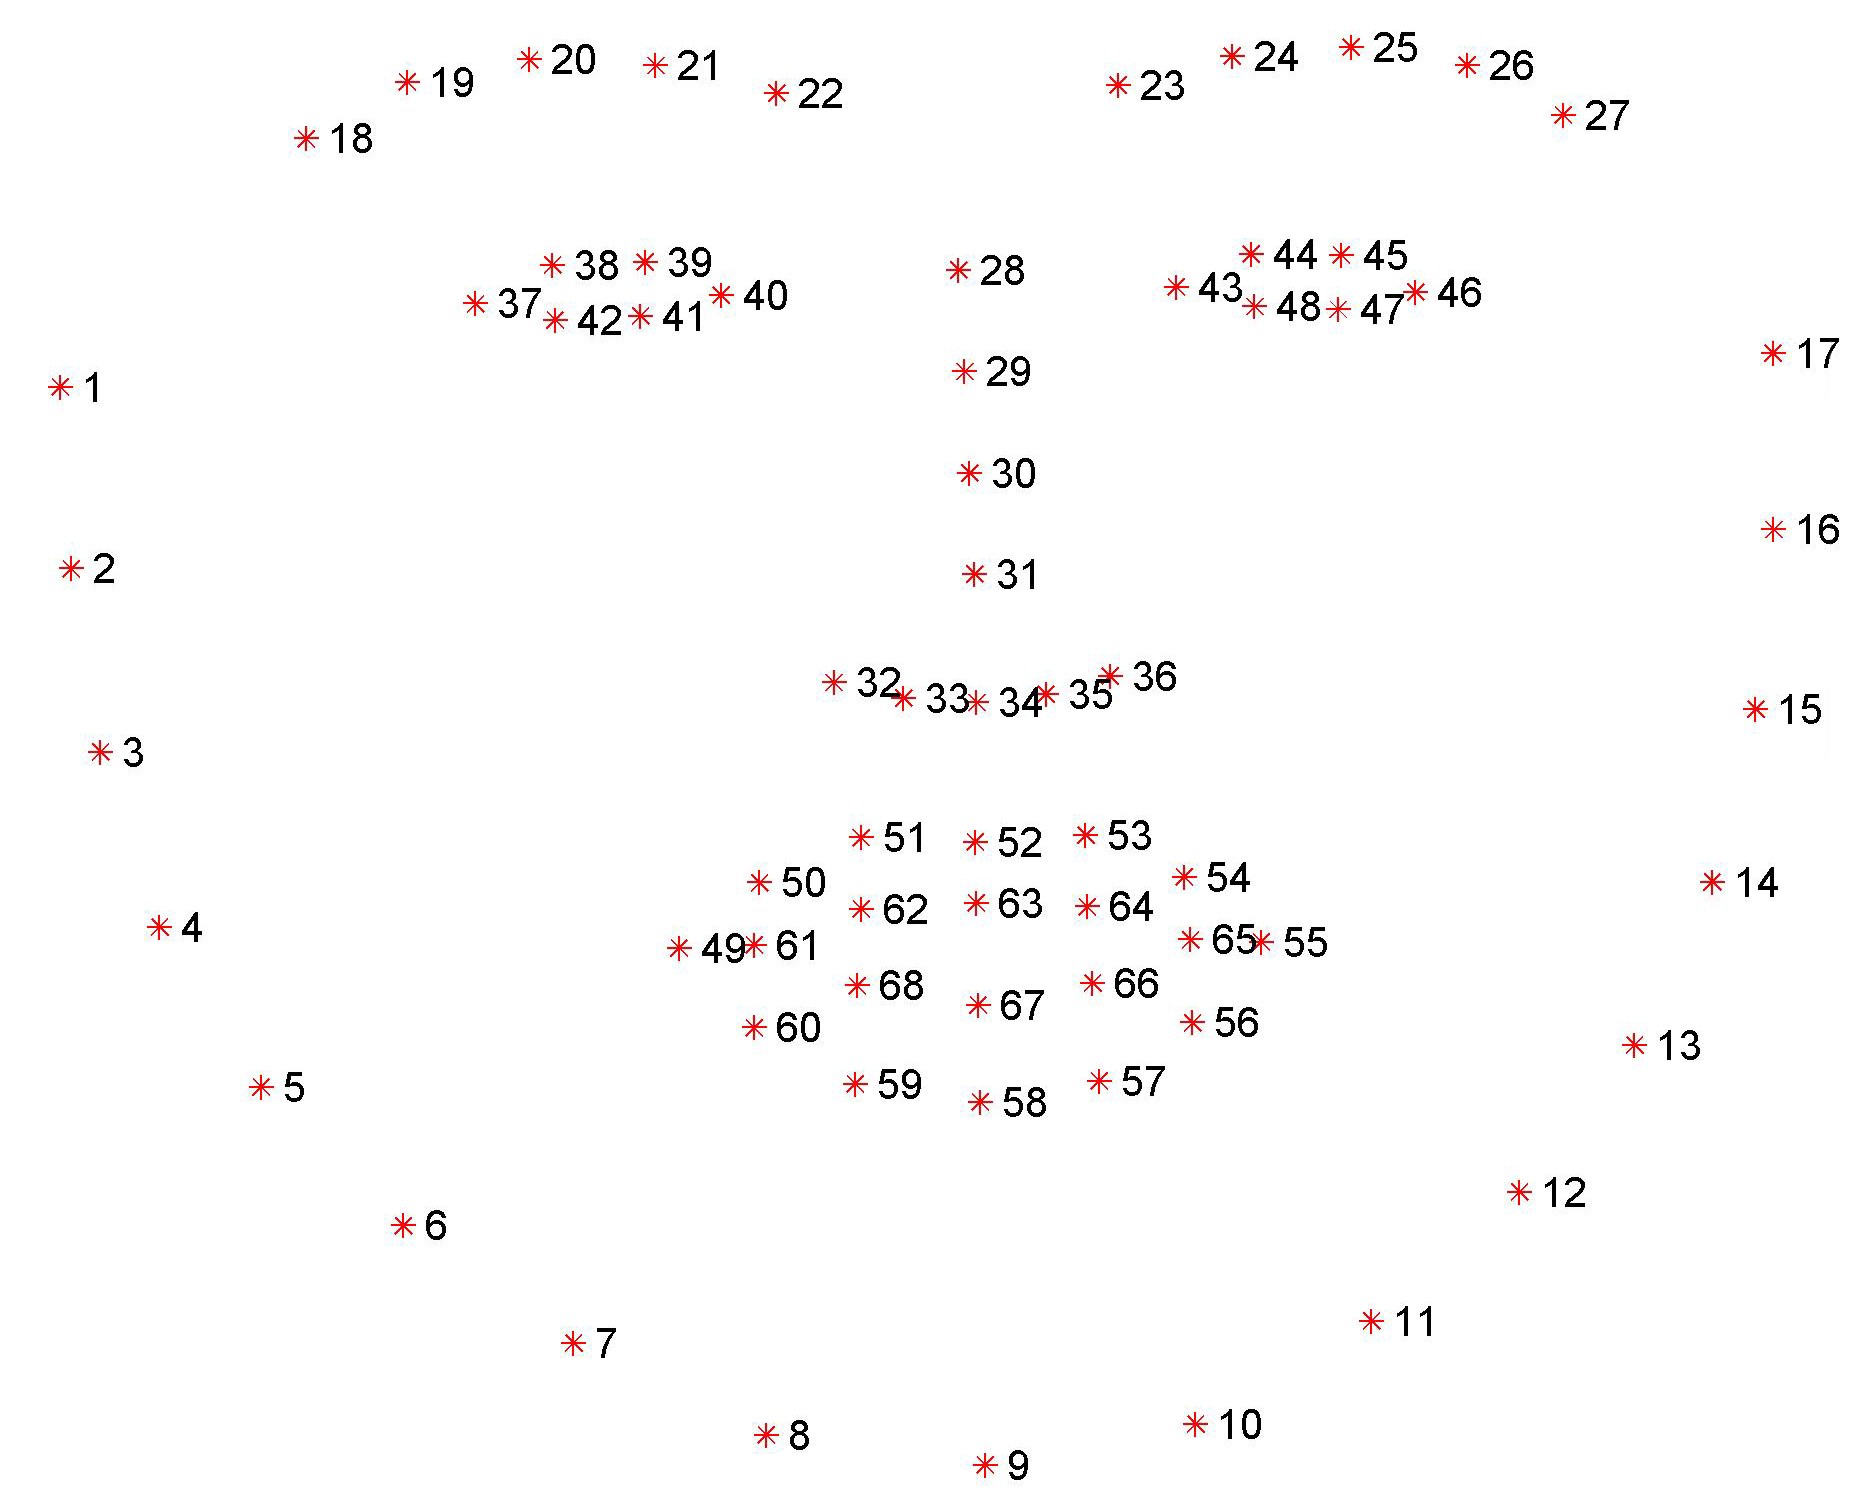

In [ ]:
# Load face detector and shape predictor from dlib
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("/content/drive/MyDrive/nn_course_work/shape_predictor_68_face_landmarks (2).dat")

# Index of the nose tip in the dlib's facial landmarks.
NOSE_TIP_IDX = 33

def extract_mouth_images(speaker, subfolder, angle, src_folder="/content/drive/MyDrive/nn_course_work/video_frames", 
                       dst_folder="/content/drive/MyDrive/nn_course_work/video_frames_mouth"):

    target_folder = os.path.join(src_folder, angle, speaker, subfolder, "/")
    for root, dirs, files in os.walk(target_folder):
        # Ensure we're in a directory for the current speaker
        if speaker not in root:
            continue  # Skip this directory if it's for a different speaker
        for file in files:
            if file.endswith(".jpg"):
                img_path = os.path.join(root, file)

                # Read the image
                img = cv2.imread(img_path)

                # Detect faces in the image
                faces = detector(img)

                # For now let's assume there's only one face in each image
                if len(faces) > 0:
                    face = faces[0]

                    # Get the landmarks/parts for the face.
                    shape = predictor(img, face)

                    # convert shape to numpy array
                    shape_np = np.array([(p.x, p.y) for p in shape.parts()])

                    # Starting point for the region of interest - the top of the nose.
                    nose_tip = shape_np[NOSE_TIP_IDX]

                    # Fixed width and height for the ROI.
                    roi_width = 200
                    roi_height = 200

                    # Adjusting starting points if the ROI goes out of the image.
                    start_x = max(0, nose_tip[0] - roi_width // 2)
                    start_y = nose_tip[1]
                    end_x = min(img.shape[1], start_x + roi_width)
                    end_y = min(img.shape[0], start_y + roi_height)

                    # Crop the ROI
                    roi = img[start_y:end_y, start_x:end_x]

                    # Write to the corresponding location in the destination folder
                    rel_dir = os.path.relpath(root, src_folder)
                    print("rel", rel_dir)
                    dst_dir = os.path.join(dst_folder, rel_dir)

                    # Create the directory if it doesn't exist
                    os.makedirs(dst_dir, exist_ok=True)

                    dst_path = os.path.join(dst_dir, file)
                    cv2.imwrite(dst_path, roi)

    print("Lip images extraction for speaker " + speaker + " and angle " + angle + " finished.")


We could have create one method for lips and images loops using callback or something else, but we decided to create seperate method, because it is more readable and we only need 2 methods👍.

In [ ]:
def extract_mouth_images_from_list(lst):
  for speaker_id, subfolder, angle in lst:
    print(f"Current speaker id {speaker_id}")
    extract_mouth_images(speaker=f"s{speaker_id}", subfolder=f"{subfolder}", angle=f"{angle}")

Wrapper method, but for above method.

In [ ]:
def extract_mouth_images_wrapper(curr_lowwer, n, subfolder, angle):
  spk_ids = np.arange(curr_lowwer, curr_lowwer + n)
  subfolders = np.full(n, subfolder)
  angles = np.full(n, angle)
  lst = zip(spk_ids,  subfolders, angles)
  extract_mouth_images_from_list(lst)

Below, are the calls to get mouth region frames for different speakers. So be careful not to run them if you do not need to parse mouth regions as we did.

**Note:** *You may see that we call our methods plenty of time, it is due to the time it takes to extract these regions and if your task is simpler you can create something that suits your needs.*

In [ ]:
extract_mouth_images_wrapper(15, 3, "l", "front")

Streaming output truncated to the last 5000 lines.
rel video_frames/front/s17/l/pgiyza
rel video_frames/front/s17/l/pgiyza
rel video_frames/front/s17/l/pgiyza
rel video_frames/front/s17/l/pgwk2s
rel video_frames/front/s17/l/pgwk2s
rel video_frames/front/s17/l/pgwk2s
rel video_frames/front/s17/l/pgwk2s
rel video_frames/front/s17/l/pgwk2s
rel video_frames/front/s17/l/pgwk2s
rel video_frames/front/s17/l/pgwk2s
rel video_frames/front/s17/l/pgwk2s
rel video_frames/front/s17/l/pgwk2s
rel video_frames/front/s17/l/pgwk2s
rel video_frames/front/s17/l/pgwk2s
rel video_frames/front/s17/l/pgwk2s
rel video_frames/front/s17/l/pgwk2s
rel video_frames/front/s17/l/pgwk2s
rel video_frames/front/s17/l/pgwk2s
rel video_frames/front/s17/l/pgwk2s
rel video_frames/front/s17/l/pgwk2s
rel video_frames/front/s17/l/pgwk2s
rel video_frames/front/s17/l/pgwk2s
rel video_frames/front/s17/l/pgwk2s
rel video_frames/front/s17/l/pgwk2s
rel video_frames/front/s17/l/pgwk2s
rel video_frames/front/s17/l/pgwk2s
rel video_fra

In [ ]:
extract_mouth_images_wrapper(18, 2, "l", "front")

In [ ]:
extract_mouth_images_wrapper(20, 1, "l", "front")

Streaming output truncated to the last 5000 lines.
rel video_frames/front/s20/l/brih7p
rel video_frames/front/s20/l/brih7p
rel video_frames/front/s20/l/brih7p
rel video_frames/front/s20/l/brih7p
rel video_frames/front/s20/l/brih7p
rel video_frames/front/s20/l/brih7p
rel video_frames/front/s20/l/brih7p
rel video_frames/front/s20/l/brih7p
rel video_frames/front/s20/l/brih7p
rel video_frames/front/s20/l/brih7p
rel video_frames/front/s20/l/brih7p
rel video_frames/front/s20/l/brih7p
rel video_frames/front/s20/l/brih7p
rel video_frames/front/s20/l/brih7p
rel video_frames/front/s20/l/brih7p
rel video_frames/front/s20/l/brih7p
rel video_frames/front/s20/l/brih7p
rel video_frames/front/s20/l/brih7p
rel video_frames/front/s20/l/brih7p
rel video_frames/front/s20/l/brih7p
rel video_frames/front/s20/l/brih7p
rel video_frames/front/s20/l/brih7p
rel video_frames/front/s20/l/brih7p
rel video_frames/front/s20/l/brih7p
rel video_frames/front/s20/l/brih7p
rel video_frames/front/s20/l/brih7p
rel video_fra

In [ ]:
extract_mouth_images_wrapper(22, 2, "l", "front")

Streaming output truncated to the last 5000 lines.
rel video_frames/front/s23/l/pgae7p
rel video_frames/front/s23/l/pgae7p
rel video_frames/front/s23/l/pgae7p
rel video_frames/front/s23/l/pgae7p
rel video_frames/front/s23/l/pgae7p
rel video_frames/front/s23/l/pgae7p
rel video_frames/front/s23/l/pgae7p
rel video_frames/front/s23/l/pgae7p
rel video_frames/front/s23/l/pgae7p
rel video_frames/front/s23/l/pgae7p
rel video_frames/front/s23/l/pgae7p
rel video_frames/front/s23/l/pgae7p
rel video_frames/front/s23/l/pgae7p
rel video_frames/front/s23/l/pgae7p
rel video_frames/front/s23/l/pgae7p
rel video_frames/front/s23/l/pgae7p
rel video_frames/front/s23/l/pgae7p
rel video_frames/front/s23/l/pgae7p
rel video_frames/front/s23/l/pgae7p
rel video_frames/front/s23/l/pgae7p
rel video_frames/front/s23/l/pgae7p
rel video_frames/front/s23/l/pgae7p
rel video_frames/front/s23/l/pgae7p
rel video_frames/front/s23/l/pgae7p
rel video_frames/front/s23/l/pgae7p
rel video_frames/front/s23/l/pgae7p
rel video_fra

In [ ]:
extract_mouth_images_wrapper(25, 2, "l", "front")

Streaming output truncated to the last 5000 lines.
rel video_frames/front/s26/l/lwbl9n
rel video_frames/front/s26/l/lwbl9n
rel video_frames/front/s26/l/lwbl9n
rel video_frames/front/s26/l/lwbl9n
rel video_frames/front/s26/l/lwbl9n
rel video_frames/front/s26/l/lwbl9n
rel video_frames/front/s26/l/lwbl9n
rel video_frames/front/s26/l/lwbl9n
rel video_frames/front/s26/l/lwbl9n
rel video_frames/front/s26/l/lwbl9n
rel video_frames/front/s26/l/lwbl9n
rel video_frames/front/s26/l/lwbl9n
rel video_frames/front/s26/l/lwbl9n
rel video_frames/front/s26/l/lwbl9n
rel video_frames/front/s26/l/lwbl9n
rel video_frames/front/s26/l/lwbl9n
rel video_frames/front/s26/l/lwbl9n
rel video_frames/front/s26/l/lwbl9n
rel video_frames/front/s26/l/lwbl9n
rel video_frames/front/s26/l/lwbl9n
rel video_frames/front/s26/l/lwbl9n
rel video_frames/front/s26/l/lwis7s
rel video_frames/front/s26/l/lwis7s
rel video_frames/front/s26/l/lwis7s
rel video_frames/front/s26/l/lwis7s
rel video_frames/front/s26/l/lwis7s
rel video_fra

In [ ]:
extract_mouth_images_wrapper(30, 3, "l", "front")

Streaming output truncated to the last 5000 lines.
rel video_frames/front/s32/l/bwwj2n
rel video_frames/front/s32/l/bwwj2n
rel video_frames/front/s32/l/bwwj2n
rel video_frames/front/s32/l/bwwj2n
rel video_frames/front/s32/l/bwwj2n
rel video_frames/front/s32/l/bwwj2n
rel video_frames/front/s32/l/lbae7a
rel video_frames/front/s32/l/lbae7a
rel video_frames/front/s32/l/lbae7a
rel video_frames/front/s32/l/lbae7a
rel video_frames/front/s32/l/lbae7a
rel video_frames/front/s32/l/lbae7a
rel video_frames/front/s32/l/lbae7a
rel video_frames/front/s32/l/lbae7a
rel video_frames/front/s32/l/lbae7a
rel video_frames/front/s32/l/lbae7a
rel video_frames/front/s32/l/lbae7a
rel video_frames/front/s32/l/lbae7a
rel video_frames/front/s32/l/lbae7a
rel video_frames/front/s32/l/lbae7a
rel video_frames/front/s32/l/lbae7a
rel video_frames/front/s32/l/lbae7a
rel video_frames/front/s32/l/lbae7a
rel video_frames/front/s32/l/lbae7a
rel video_frames/front/s32/l/lbae7a
rel video_frames/front/s32/l/lbae7a
rel video_fra

Just like previously, we used our `create_zip_from_folder` up until we found out about feature of Google Drive.

In [ ]:
# create_zip_from_folder("/content/drive/MyDrive/nn_course_work/video_frames_lips/video_frames/front", "/content/lips_18_20.zip")